In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import math
import pickle
from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler, power_transform
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_predict
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss, acf, pacf
from collections import defaultdict, OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.decomposition import PCA
from statsmodels.tsa.ar_model import AR
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df_v2 = pd.read_csv("df_v3.csv")

In [4]:
df_v2

,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,casual,registered,total_cust,holiday,rain,fog,ice,datetime,year,month,dayOfWeek
0,2011-01-01,5.20,-1.57,11.97,2.77,0.07,2.58,330.0,629.0,959.0,0.0,1,1,0,2011-01-01,2011,January,Saturday
1,2011-01-02,7.34,0.88,13.81,7.33,1.04,3.92,130.0,651.0,781.0,0.0,1,1,0,2011-01-02,2011,January,Sunday
2,2011-01-03,2.01,-3.44,7.46,-3.06,1.88,3.62,120.0,1181.0,1301.0,0.0,0,0,0,2011-01-03,2011,January,Monday
3,2011-01-04,-0.66,-5.96,4.64,-3.10,0.00,1.80,107.0,1429.0,1536.0,0.0,0,0,0,2011-01-04,2011,January,Tuesday
4,2011-01-05,0.91,-4.29,6.11,-1.77,0.00,2.95,82.0,1489.0,1571.0,0.0,0,0,0,2011-01-05,2011,January,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,3.50,-3.59,9.12,-1.06,0.02,2.10,1150.0,4280.0,5430.0,0.0,0,1,0,2018-12-27,2018,December,Thursday
2918,2018-12-28,8.23,0.61,11.21,8.09,16.84,2.00,166.0,1959.0,2125.0,0.0,0,1,0,2018-12-28,2018,December,Friday
2919,2018-12-29,9.50,3.93,12.42,5.31,11.55,3.67,1756.0,4252.0,6008.0,0.0,0,1,0,2018-12-29,2018,December,Saturday
2920,2018-12-30,4.80,0.82,11.07,2.09,0.10,1.20,1295.0,3634.0,4929.0,0.0,0,0,0,2018-12-30,2018,December,Sunday


In [5]:
df_v2.describe()

,temp_avg,temp_min,temp_max,temp_observ,precip,wind,casual,registered,total_cust,holiday,rain,fog,ice,year
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,14.072317,8.506598,19.015674,11.069251,3.435623,3.163042,1677.561602,6042.021561,7719.583162,0.030459,0.323751,0.631417,0.094456,2014.499658
std,9.536753,9.473867,9.835377,9.481130,8.183749,1.379595,1560.840858,2757.419767,3746.759171,0.171875,0.467986,0.482503,0.292512,2.291531
min,-12.100000,-16.990000,-7.980000,-15.660000,0.000000,0.380000,2.000000,19.000000,21.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,6.000000,0.520000,11.080000,3.015000,0.010000,2.200000,510.250000,3828.500000,4621.250000,0.000000,0.000000,0.000000,0.000000,2012.250000
50%,14.770000,8.505000,19.990000,11.620000,0.270000,2.900000,1217.500000,5959.000000,7439.000000,0.000000,0.000000,1.000000,0.000000,2014.500000
75%,22.800000,17.337500,27.877500,19.767500,2.887500,3.880000,2355.000000,8183.750000,10847.750000,0.000000,1.000000,1.000000,0.000000,2016.000000
max,32.030000,26.210000,37.850000,28.670000,118.790000,12.750000,10173.000000,15419.000000,19113.000000,1.000000,1.000000,1.000000,1.000000,2018.000000


In [6]:
df_v2.columns

Index(['date', 'temp_avg', 'temp_min', 'temp_max', 'temp_observ', 'precip',
       'wind', 'casual', 'registered', 'total_cust', 'holiday', 'rain', 'fog',
       'ice', 'datetime', 'year', 'month', 'dayOfWeek'],
      dtype='object')

In [7]:
df_v2['total_cust']

0        959.0
1        781.0
2       1301.0
3       1536.0
4       1571.0
         ...  
2917    5430.0
2918    2125.0
2919    6008.0
2920    4929.0
2921    2401.0
Name: total_cust, Length: 2922, dtype: float64

<Axes: >

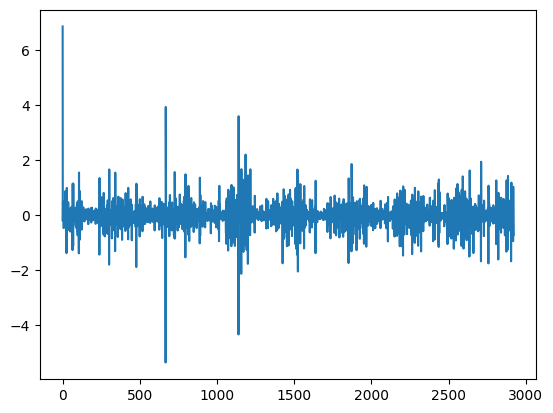

In [8]:
#here, we compute the difference of consecutive terms in the series.
#We will also perform log transform
df_v2['total_cust_log'] = np.log(df_v2['total_cust'])
df_v2['total_cust_diff'] = df_v2['total_cust_log']-df_v2['total_cust_log'].shift(periods=1, freq=None, axis=0, fill_value=0)
df_v2['total_cust_diff'].dropna().plot()

When learning about time series, we came to know that to make to make time series stationary there are certain tests which needs to be done. These test are as per mentioned in the online resources available used for handling stationary time series.

In [9]:
#Augmented Dickey Fuller Test to make the time series stationary
def adf_test(df, col_names):
    for name in col_names:
        print ('Results of Augmented Dickey-Fuller Test for {}'.format(name))
        result_test = adfuller(df[name], autolag='AIC')
        result_output = pd.Series(result_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, val in result_test[4].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)

In [10]:
testing_df = pd.DataFrame()
testing_features = [ 'precip','fog','temp_min', 'temp_max','wind','total_cust']

for col in testing_features:
    col_mean = df_v2[col].rolling(16).mean()[15:-1]
    col_std = df_v2[col].rolling(16).std()[15:-1]
    testing_df[col+'_mean16'] = col_mean.values
    testing_df[col+'_std16'] = col_std.values

In [12]:
## adf test for total_customers
from statsmodels.tsa.stattools import adfuller
adf_test(df_v2, ['total_cust'])

Results of Augmented Dickey-Fuller Test for total_cust
Test Statistic                   -3.068277
p-value                           0.028992
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [13]:
# adf test for total_cust_total-2
adf_test(df_v2, ['total_cust_diff'])

Results of Augmented Dickey-Fuller Test for total_cust_diff
Test Statistic                -1.586558e+01
p-value                        9.106081e-29
#Lags Used                     2.500000e+01
Number of Observations Used    2.896000e+03
Critical Value (1%)           -3.432610e+00
Critical Value (5%)           -2.862539e+00
Critical Value (10%)          -2.567302e+00
dtype: float64


In [14]:
adf_test(testing_df, testing_df.columns)

Results of Augmented Dickey-Fuller Test for precip_mean16
Test Statistic                -8.653360e+00
p-value                        5.045121e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.878000e+03
Critical Value (1%)           -3.432624e+00
Critical Value (5%)           -2.862545e+00
Critical Value (10%)          -2.567305e+00
dtype: float64
Results of Augmented Dickey-Fuller Test for precip_std16
Test Statistic                -8.039646e+00
p-value                        1.861900e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.889000e+03
Critical Value (1%)           -3.432616e+00
Critical Value (5%)           -2.862541e+00
Critical Value (10%)          -2.567303e+00
dtype: float64
Results of Augmented Dickey-Fuller Test for fog_mean16
Test Statistic                -6.086270e+00
p-value                        1.062562e-07
#Lags Used                     1.700000e+01
Number of Observations Used    2.888000e+03
Critical

**Test for Augmented Dickey Fuller, or ADF:**
Among the statistical tests is the Dickey Fuller test. It can be used to ascertain whether the series has a unit root, which will enable us to determine whether the series is stationary or not. The following are the test's alternate and null hypotheses:

Null hypothesis  says Data is not stationary
An alternate theory states that the data is stationary.

**The results can be interpret as below:**
-If critical value> test_statistic than null hypothesis is rejected ie data is stationary
-If critical value< test_statistic than null hypothesis is not rejected ie data is not stationar

Advanced techniques such as trend stationarity and difference stationarity can be used to verify stationarity. The KPSS test is required to determine trend stationarity. The findings indicate that there is non-stationarity between total_cust and total_cust_total-2 at the 1% level.

The KPSS test must be implemented in order to determine the stationarity trend in timeseries data.

In [15]:
#kwiatkowski-Phillips-Schmidt-Shin Test
from statsmodels.tsa.stattools import kpss

In [16]:
def kpss_test(df, col_names):
    for name in col_names:
        print ('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c', lags='legacy')
        result_output = pd.Series(result_test[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)

In [22]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df, col_names):
    for name in col_names:
        print('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c')  # Remove 'lags' parameter
        result_output = pd.Series(result_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)' % key] = val
        print(result_output)

# kpss test for total_cust
kpss_test(df_v2, ['total_cust'])


Results of KPSS Test for total_cust
Test Statistic            4.164139
p-value                   0.010000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-22-c91dc646f988>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_test = kpss(df[name], regression='c')  # Remove 'lags' parameter


In [23]:
# kpss test for total_cust_t-1
kpss_test(df_v2, ['total_cust_diff'])

Results of KPSS Test for total_cust_diff
Test Statistic             0.379264
p-value                    0.086093
Lags Used                153.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


In [24]:
# kpss test for total_cust
kpss_test(testing_df, testing_df.columns)

Results of KPSS Test for precip_mean16
Test Statistic            0.186965
p-value                   0.100000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_std16
Test Statistic            0.126096
p-value                   0.100000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for fog_mean16
Test Statistic            0.401915
p-value                   0.076330
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for fog_std16
Test Statistic            0.406448
p-value                   0.074376
La

<ipython-input-22-c91dc646f988>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_test = kpss(df[name], regression='c')  # Remove 'lags' parameter
<ipython-input-22-c91dc646f988>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_test = kpss(df[name], regression='c')  # Remove 'lags' parameter
<ipython-input-22-c91dc646f988>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_test = kpss(df[name], regression='c')  # Remove 'lags' parameter
<ipython-input-22-c91dc646f988>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greate

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is a statistical tool used to determine whether a series centered on a deterministic trend is stationar. Similar to the ADF test, the KPSS test is frequently employed to evaluate a series' stationarity. In terms of functionality and actual use, it differs significantly from the ADF test in a few important ways.

The null hypothesis states that the data is steady.
A different theory claims that the data is not stationary.

The findings can be explained as follows:
-If critical value < test_statistic, the null hypothesis (that is, the data are not stationary) is rejected.
-The null hypothesis, i.e., that the data is stationar, is not rejected if critical value >test statistic


The timeseries must either show a difference or a stationary trend in order for the transformation to be necessary.

If a timeseries is trend stationary and a difference, then no transformations are required. If a timeseries is not trend stationary but is not a difference, then total_cust transformations are required.
In the event that the timeseries is neither stationary in trend nor different, transformations of total_cust_total-2 are required.